## Testing trained models on various images:
  * load in saved hats,glasses, and beard models 
  * test each model on the same single image and compare image results 
      * try on all pics, randomly select a one from data/pics
      * try how it works on noncropped images
   
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.
W0829 23:33:10.565872 140048195270464 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0829 23:33:10.566697 140048195270464 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



---
#### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_preprocessing.image import load_img, img_to_array
from keras.models import model_from_json
import os

---
#### Import pretrained models: 

In [3]:
def load_pretrained_models(file_path):
    '''
    inputs:
    file_path2: path to saved best weights as h5 
    returns:
    saved models
    '''
    # load json and create model
    json_file = open('../tuning_data/vgg_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load model weight 
    loaded_model.load_weights(file_path)
    return loaded_model

#### Load all three models

In [4]:
glasses_model =load_pretrained_models('../tuning_data/best_vgg_model_eyewears.h5')
glasses_model_2 =load_pretrained_models('../tuning_data/best_vgg_model_eyewears_2.h5')

glasses_model_3 =load_pretrained_models('../tuning_data/best_vgg_model_eyewears_3.h5')

hat_model = load_pretrained_models('../tuning_data/best_vgg_model_hat.h5')

beard_model = load_pretrained_models('../tuning_data/best_vgg_model_beard.h5')
beard_model_2 = load_pretrained_models('../tuning_data/best_vgg_model_beard_2.h5')

W0829 23:33:28.809128 140048195270464 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 23:33:28.822352 140048195270464 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 23:33:28.832034 140048195270464 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 23:33:28.835805 140048195270464 deprecation.py:506] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be rem

#### WARNINGS: in all three cases, 0 means yes and 1 means no 

### Checking images:

#### convert jpg image into np.array as data input

In [125]:
def test_image(model,filepath,label):
    '''
    inputs:
    model: saved model
    filepath: path to file with images 
    label: a string, eyewear, hat, or beard
    returns:
    print an image plus labels
    '''
    files = os.listdir(filepath)
    choice = np.random.choice(files)
    img = load_img(os.path.join(filepath,choice),target_size=(150,150))
    plt.imshow(img)
    plt.show()
    img = img_to_array(img)/255
    img = np.expand_dims(img,axis=0)
    if np.around(model.predict(img))[0]:  # 1 means no and 0 means yes
        print(f'No {label}')
    else:
        print(f'YES {label}')
    

In [5]:
def test_image_2(model,filepath,label):
    '''
    inputs:
    model: saved model
    filepath: path to file with images 
    label: a string, eyewear, hat, or beard
    returns:
    print an image plus labels
    '''
    files = os.listdir(filepath)
    total = len(files)
    correct = 0 
    for file in files:
        img = load_img(os.path.join(filepath,file),target_size=(150,150))
        img = img_to_array(img)/255
        img = np.expand_dims(img,axis=0)
        if not np.around(model.predict(img))[0]:  # 1 means no and 0 means yes
            correct += 1
    return correct/total

### Randomly test on eyewear model 

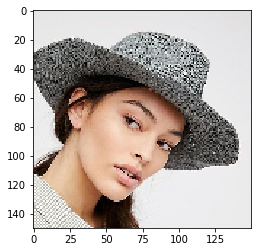

No eyewear


In [22]:
test_image(glasses_model_2, '../data/pics', 'eyewear')

### Test on noncropped images 

In [ ]:
test_image(glasses_model_2, '/Datastore/GoogleImages/selected/sunglasses/','eyewear')

In [6]:
test_image_2(glasses_model_3, '/Datastore/GoogleImages/selected/sunglasses/','eyewear')

# needs thick ridges to pick up glasses, need to separate glasses from sunglasses 

0.7587412587412588

In [7]:
test_image_2(glasses_model_3, '/Datastore/GoogleImages/selected/glasses/','eyewear')

0.73992673992674

In [7]:
test_image_2(glasses_model_2, '/Datastore/GoogleImages/selected/sunglasses/','eyewear')

0.8986013986013986

In [8]:
test_image_2(glasses_model_2, '/Datastore/GoogleImages/selected/glasses/','eyewear')

0.8424908424908425

### Randomly test on beard model 

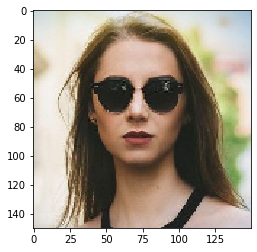

No beard


In [25]:
test_image(beard_model, '../data/pics', 'beard')

### Test on noncropped images 

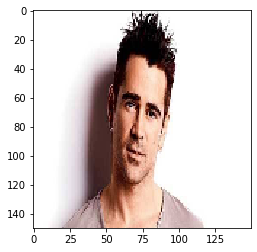

No beard


In [52]:
test_image(beard_model, '../data/zoom_out/','beard')

### Randomly test on hat model 

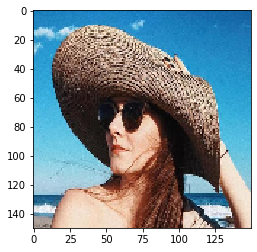

YES hat


In [61]:
test_image(hat_model, '../data/pics', 'hat')

In [11]:
test_image_2(beard_model_2, '/Datastore/GoogleImages/selected/beard/','beard')

0.5207667731629393

In [132]:
test_image_2(hat_model, '/Datastore/GoogleImages/selected/hat/','hat')

0.9137254901960784

### Test on noncropped images 

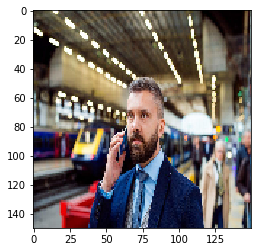

YES hat


In [68]:
test_image(hat_model, '../data/zoom_out/','hat')